# 0.6 Hebbian Learning

## Boilerplate

The following subsections are largely boilerplate code, so skip around as needed.

### Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn,tensorflow

Mon Mar 25 2019 23:48:17 

CPython 3.6.8
IPython 7.3.0

numpy 1.16.2
matplotlib 3.0.2
seaborn 0.9.0
tensorflow 1.10.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.18.0-16-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 100d2741e0dadbc8df124ba2675596a49345a572
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode.
%matplotlib inline

### Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [4]:
# Standard library imports
import logging
import os
from functools import wraps
from pathlib import Path

# Third party
import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [5]:
# Import the whole module
%aimport leabratf
import leabratf as ltf
# Task script
%aimport leabratf.tasks.combinatorics.combigen
import leabratf.tasks.combinatorics.combigen as cg
# Visualization for the task
%aimport leabratf.visualization.combigen_heatmap
import leabratf.visualization.combigen_heatmap as cgh
# Metrics visulaization
%aimport leabratf.visualization.metrics
import leabratf.visualization.metrics as plt_metrics
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging
# Tensorflow Utility functions
%aimport leabratf.tfutils
from leabratf.tfutils import lazy_property
# Constants
%aimport leabratf.constants
from leabratf.constants import DIR_DATA_PROC

### Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [6]:
sns.set()
sns.set_context("notebook")

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [7]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger('leabratf')
# Don't propagate messages
logger.propagate = False

### Global Variables

#### Combigen Task Variables

In [8]:
# Number of slots in a training set
STACK = 4
# Size of each axis in the input array
SIZE = 5
# Number of axes to use per slot
DIMS = 2
# Number of lines per axis
LINES = [1,1]

#### Data Parameters

In [9]:
# Number of epochs to train for
EPOCHS = 500
# Number of samples in the training set
N_TRAIN = 100
# Number of samples in the validation set
N_VAL = 50
# Number of samples in the testing set
N_TEST = 500

#### Datasets

In [10]:
# Training Data
Y_TRAIN = cg.generate_labels(n_samples=N_TRAIN, stack=STACK, size=SIZE, dims=DIMS, n_lines=LINES)
X_TRAIN = cg.inverse_transform(Y_TRAIN)
# Validation Data
Y_VAL = cg.generate_labels(n_samples=N_VAL, stack=STACK, size=SIZE, dims=DIMS, n_lines=LINES)
X_VAL = cg.inverse_transform(Y_VAL)
# Testing data
Y_TEST = cg.generate_labels(n_samples=N_TEST, stack=STACK, size=SIZE, dims=DIMS, n_lines=LINES)
X_TEST = cg.inverse_transform(Y_TEST)

#### Network Parameters

In [11]:
# Learning rate
ALPHA = 0.01
# Batch size
BATCH_SIZE = 1
# Number of parameters in the inputs
N_INPUTS = STACK * SIZE ** DIMS
# Number of hidden units
N_HIDDEN_1 = 100
# Number of parameters in the labels
N_OUTPUTS = STACK * SIZE * DIMS

#### Training Parameters

In [12]:
# Number of times to print an update
N_UPDATES = 2
# Which device to train on
TF_DEVICE = '/cpu:0'
# Number of models to train with
N_MODELS = 10

## Background

This section goes over some of the background information for the notebook using results from previous notebooks. Skip around as needed.

### The Combigen Task

Quickly remind ourselves what the task looks like before diving in.

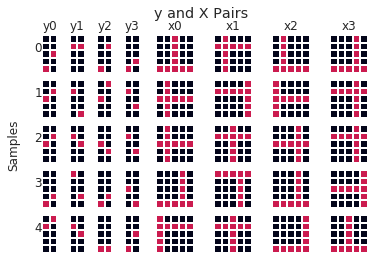

In [13]:
cgh.visualize_combigen(5)
plt.show()

## Setting Up the Graph

This next section will define the computational graph that will be used to generate the metrics down below. It is largely code copied from nb-0.3, so skip around as needed.

In [95]:
# Cleanup any residual nodes
tf.reset_default_graph()

init_ops = []

### Make the Datasets

Define the various `tf.Dataset`s that will be used.

In [73]:
def make_tf_datasets(init_ops=None):
    # The first step of the setup is that each of the datasets (training, validation, and 
    # testing) are turned into their own `Dataset` objects.
    # Training dataset
    dataset_train = tf.data.Dataset.from_tensor_slices(
        (X_TRAIN, Y_TRAIN)).repeat().batch(BATCH_SIZE)
    # Validation dataset
    dataset_val = tf.data.Dataset.from_tensor_slices(
        (X_VAL, Y_VAL)).repeat().batch(BATCH_SIZE)
    # Testing dataset
    dataset_test = tf.data.Dataset.from_tensor_slices(
        (X_TEST, Y_TEST)).repeat().batch(BATCH_SIZE)
    
    # Next, let's define the iterators for each of the datasets, and then add their 
    # initializations to the `init_ops` list.
    # Training iterator
    train_iter = dataset_train.make_initializable_iterator()
    # Validation iterator
    val_iter = dataset_val.make_initializable_iterator()
    # Testing iterator
    test_iter = dataset_test.make_initializable_iterator()
    # Aggregate the iterators
    iterators = [train_iter, val_iter, test_iter]

    # Add the initiatlizations to the init opts
    init_ops = init_ops or []
    init_ops += [train_iter.initializer, val_iter.initializer, test_iter.initializer]
    
    # And finally, the interesting part. Rather than creating separate next elements for 
    # the model, the `tf.data` API has a string handler iterator so we can contextually 
    # switch the active `Dataset` object, resulting in different values being used for `x` 
    # and `y`.

    # The way this is done is by defining a `tf.placeholder` variable, which is used 
    # first to create a string handler iterator, and later to hold the dataset-indicating 
    # string handle. The string handler iterator is what then changes the values of `x` and 
    # `y`, naturally also supplying them using the `get_next` method.
    # The placeholder variable of type string
    handle = tf.placeholder(tf.string, shape=[])
    # Iterator from string handle
    handle_iterator = tf.data.Iterator.from_string_handle(
        handle, dataset_train.output_types, 
        dataset_train.output_shapes)

    # x and y that will be used in the graph
    x, y = handle_iterator.get_next()
    
    return x, y, iterators, handle, init_ops

### Model Class

An implementation change that will be made going forward is to have the model components in a class.

In [45]:
class OReillyModel:
    def __init__(self, inputs, name='or_model'):
        self.name = name 
        self.inputs = inputs
        with tf.variable_scope(self.name):
            self.weights = {'h1': tf.get_variable(
                                    name='w_h1',
                                    shape=[N_INPUTS, N_HIDDEN_1],
                                    initializer=tf.contrib.layers.xavier_initializer()),
                            'out': tf.get_variable(
                                    name='w_out', 
                                    shape=[N_HIDDEN_1, N_OUTPUTS],
                                    initializer=tf.contrib.layers.xavier_initializer()),
                            }  
            self.biases = {'b1': tf.get_variable(
                                name="b_1", 
                                shape=[N_HIDDEN_1], 
                                initializer=tf.zeros_initializer()),
                            'out': tf.get_variable(
                                name="b_out", 
                                shape=[N_OUTPUTS], 
                                initializer=tf.zeros_initializer()),
                            }
            self.logits
        
    @lazy_property
    def logits(self):
        """Logits lazy property that returns the logits of the model"""
        with tf.variable_scope(self.name):
            # Reshape for hidden layer
            self.inp_reshaped = tf.reshape(self.inputs, shape=[1, N_INPUTS])
            # Single hidden layer
            self.h1_layer_logits = tf.sigmoid(tf.add(tf.matmul(
                self.inp_reshaped, self.weights['h1']), self.biases['b1']))
            # Output layer
            self.out_layer_logits = tf.add(tf.matmul(
                self.h1_layer_logits, self.weights['out']), self.biases['out'])
            # Reshape for labels
            return tf.reshape(self.out_layer_logits, shape=[1, STACK, SIZE, DIMS])

### Instantiate all the Ops

In [46]:
with tf.device(TF_DEVICE):
    # Get the relevant dataset nodes
    x, y, iterators, handle, init_ops = make_tf_datasets(init_ops)
    # Build the model
    model = OReillyModel(x, name='or_model')
    # Grab the logits
    logits = model.logits
    
    # Ensure y is cast to the same type as logits
    labels = tf.cast(y, logits.dtype)
    
    # We will keep this in for now
    # Define alpha as placeholder variable
    alpha_ph = tf.placeholder(tf.float32, shape=[])

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logits, labels=labels))

    # Define some intermediate nodes
    predictions = tf.sigmoid(logits)
    rounded_predictions = tf.round(predictions)
    equal_labels_and_preds = tf.equal(rounded_predictions, labels)
    
    # O'Reilly Accuracy 
    axis_acc = tf.reduce_all(equal_labels_and_preds, axis=(2))
    slot_acc = tf.reduce_all(axis_acc, axis=(2))
    sample_acc = tf.reduce_all(slot_acc, axis=(1))
 
    # Elemental Accuracy 
    el_acc_op = tf.reduce_mean(tf.cast(equal_labels_and_preds, tf.float16))
    # Axis Accuracy
    axis_acc_op = tf.reduce_mean(tf.cast(axis_acc, tf.float16))
    # Slot Accuracy
    slot_acc_op = tf.reduce_mean(tf.cast(slot_acc, tf.float16))
    # Sample Accuracy
    sample_acc_op = tf.reduce_mean(tf.cast(sample_acc, tf.float16))
    
    # Train op
    train_op = tf.train.GradientDescentOptimizer(alpha_ph).minimize(loss_op)

### New Session Function

In the event that we do not want to immediately close sessions, we won't be using the context handler but will still need to grab new sessions as necessary. So let's quickly write a function that will properly run `sess.close()` if a previous session exists and then return a new `tf.Session` instance.

In [15]:
def new_session(*args, **kwargs):
    # Try to close the globally defined session if it isn't already
    try:
        if not sess._closed:
            sess.close()
    # If it doesn't exist, then just pass
    except NameError:
        pass
    # Return the new instance
    return tf.Session(*args, **kwargs)

### Defining the Training Function

Let's define a function that runs the training routine and accepts the number of epochs as the inputs.

In [48]:
def train(sess, lr=ALPHA, epochs=EPOCHS, n_updates=N_UPDATES,
          init_ops=None):
    # Ensure this is an int
    epochs = int(epochs)
    # Dict with the various metrics we care about
    metrics = {'loss':[], 'el_acc':[], 'ax_acc':[], 'sl_acc':[], 'sm_acc':[], 
               'val_loss':[], 'val_el_acc':[], 'val_ax_acc':[], 'val_sl_acc':[], 
               'val_sm_acc':[]}
    # Run the initialization ops
    init_ops = init_ops or []
    init_ops += [tf.global_variables_initializer(), tf.local_variables_initializer()]
    sess.run(init_ops)
    # Define training and validation handlers
    training_handle, validation_handle, testing_handle = sess.run([i.string_handle() 
                                                                   for i in iterators])

    for epoch in range(epochs):
        ep_loss, ep_el_acc, ep_sl_acc, ep_ax_acc, ep_sm_acc = np.zeros([5, N_TRAIN])
        # Run the training steps
        for i in range(N_TRAIN):
            _, ep_loss[i], ep_el_acc[i], ep_sl_acc[i], ep_ax_acc[i], ep_sm_acc[i] = sess.run(
                [train_op, loss_op, el_acc_op, axis_acc_op, slot_acc_op, sample_acc_op],
                feed_dict={handle: training_handle, alpha_ph: lr})
            
        # Get means for the epoch
        epoch_data = list(np.mean((ep_loss, ep_el_acc, ep_sl_acc, ep_ax_acc, ep_sm_acc), 
                                  axis=1))

        # Calculate validation accuracy and loss
        val_data = list(sess.run([loss_op, el_acc_op, axis_acc_op, slot_acc_op, sample_acc_op],
                                 feed_dict={handle: validation_handle}))
        
        # Record
        for key, value in zip(metrics.keys(), epoch_data + val_data):
            metrics[key].append(value)

        # Selectively display the epoch number
        if n_updates and (not epoch % (epochs / n_updates) or epoch == epochs - 1):
            print(("Completed epoch {0}/{1}. Metrics:\n" + 
                   "                     Loss   Sample Accuracy   Elem Accuracy\n" +
                   "    Epoch:      {2:10.4f}   {3:10.4f}   {4:10.4f}\n" +
                   "    Validation: {5:10.4f}   {6:10.4f}   {7:10.4f}\n").format(
                epoch+1, epochs, epoch_data[0],epoch_data[4], epoch_data[1], 
                val_data[0], val_data[4], val_data[1]))

    # Calculate accuracy for test images
    print("Optimization Finished! Testing Sample Accuracy:", sess.run(
        sample_acc_op, feed_dict={handle: testing_handle}))
    return metrics

### Baseline metrics

Just as a sanity check, let's run the new class model with a learning rate of 0.1 so we can get good results relatively quickly.

In [51]:
def exp_test():
    sess = new_session()
    metrics_list = []
    for i in range(N_MODELS):
        metrics_list.append(train(sess, lr=0.1, epochs=EPOCHS, n_updates=0, init_ops=init_ops))
    return metrics_list
metrics = exp_test()

Optimization Finished! Testing Sample Accuracy: 0.294
Optimization Finished! Testing Sample Accuracy: 0.286
Optimization Finished! Testing Sample Accuracy: 0.282
Optimization Finished! Testing Sample Accuracy: 0.296
Optimization Finished! Testing Sample Accuracy: 0.306
Optimization Finished! Testing Sample Accuracy: 0.252
Optimization Finished! Testing Sample Accuracy: 0.304
Optimization Finished! Testing Sample Accuracy: 0.276
Optimization Finished! Testing Sample Accuracy: 0.29
Optimization Finished! Testing Sample Accuracy: 0.294


## Hebbian Weight Update

In [178]:
# Cleanup any residual nodes
tf.reset_default_graph()

init_ops = []

In [179]:
class HebbianModel(OReillyModel):
    def __init__(self, inputs, name='hebb_model', k=0.02, *args, **kwargs):
        super().__init__(inputs, name=name, *args, **kwargs)
        self.k = k 
    
    def get_hebbian_weight_update(self):
        """Weight update according to O'Reilly."""
        with tf.variable_scope(self.name):
            # w_h1 delta
            x_plus = tf.reshape(ltf.tfutils.repeat(self.inp_reshaped, [1, N_HIDDEN_1]), 
                           [1, N_INPUTS, N_HIDDEN_1])
            y_plus = tf.reshape(tf.tile(self.h1_layer_logits, [1, N_INPUTS]), 
                           [1, N_INPUTS, N_HIDDEN_1])
            self.w_h1_delta = tf.reshape(tf.multiply(
                y_plus, x_plus - self.weights['h1']), self.weights['h1'].shape)

            # w_out delta
            x_plus = tf.reshape(ltf.tfutils.repeat(self.h1_layer_logits, [1, N_OUTPUTS]), 
                           [1, N_HIDDEN_1, N_OUTPUTS])
            y_plus = tf.reshape(tf.tile(self.out_layer_logits, [1, N_HIDDEN_1]), 
                           [1,  N_HIDDEN_1, N_OUTPUTS])
            self.w_out_delta = tf.reshape(tf.multiply(
                y_plus, x_plus - self.weights['out']), self.weights['out'].shape)
            return [self.w_h1_delta, self.w_out_delta]
        
    def hebbian_update(self):
        with tf.variable_scope(self.name):
            self.hebb_assign_h1 = self.weights['h1'].assign(self.weights['h1'] - self.k*alpha_ph*self.w_h1_delta)
            self.hebb_assign_out = self.weights['out'].assign(self.weights['out'] - self.k*alpha_ph*self.w_out_delta)
            return [self.hebb_assign_h1, self.hebb_assign_out]

In [180]:
with tf.device(TF_DEVICE):
    # Get the relevant dataset nodes
    x, y, iterators, handle, init_ops = make_tf_datasets(init_ops)
    # Build the model
    model = HebbianModel(x)
    # Grab the logits
    logits = model.logits
    
    # Ensure y is cast to the same type as logits
    labels = tf.cast(y, logits.dtype)
    
    # We will keep this in for now
    # Define alpha as placeholder variable
    alpha_ph = (1.0-model.k) * tf.placeholder(tf.float32, shape=[])

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logits, labels=labels))

    # Define some intermediate nodes
    predictions = tf.sigmoid(logits)
    rounded_predictions = tf.round(predictions)
    equal_labels_and_preds = tf.equal(rounded_predictions, labels)
    
    # O'Reilly Accuracy 
    axis_acc = tf.reduce_all(equal_labels_and_preds, axis=(2))
    slot_acc = tf.reduce_all(axis_acc, axis=(2))
    sample_acc = tf.reduce_all(slot_acc, axis=(1))
 
    # Elemental Accuracy 
    el_acc_op = tf.reduce_mean(tf.cast(equal_labels_and_preds, tf.float16))
    # Axis Accuracy
    axis_acc_op = tf.reduce_mean(tf.cast(axis_acc, tf.float16))
    # Slot Accuracy
    slot_acc_op = tf.reduce_mean(tf.cast(slot_acc, tf.float16))
    # Sample Accuracy
    sample_acc_op = tf.reduce_mean(tf.cast(sample_acc, tf.float16))
    
    # Train op
    train_op = tf.train.GradientDescentOptimizer(alpha_ph).minimize(loss_op)
    
    # Hebbian ops
    hebb_updates = model.get_hebbian_weight_update()
    hebb_assigns = model.hebbian_update()

In [181]:
def train_hebbian(sess, lr=ALPHA, epochs=EPOCHS, n_updates=N_UPDATES,
          init_ops=None):
    # Ensure this is an int
    epochs = int(epochs)
    # Dict with the various metrics we care about
    metrics = {'loss':[], 'el_acc':[], 'ax_acc':[], 'sl_acc':[], 'sm_acc':[], 
               'val_loss':[], 'val_el_acc':[], 'val_ax_acc':[], 'val_sl_acc':[], 
               'val_sm_acc':[]}
    # Run the initialization ops
    init_ops = init_ops or []
    init_ops += [tf.global_variables_initializer(), tf.local_variables_initializer()]
    sess.run(init_ops)
    # Define training and validation handlers
    training_handle, validation_handle, testing_handle = sess.run([i.string_handle() 
                                                                   for i in iterators])

    for epoch in range(epochs):
        ep_loss, ep_el_acc, ep_sl_acc, ep_ax_acc, ep_sm_acc = np.zeros([5, N_TRAIN])
        # Run the training steps
        for i in range(N_TRAIN):
            *_, ep_loss[i], ep_el_acc[i], ep_sl_acc[i], ep_ax_acc[i], ep_sm_acc[i] = sess.run(
                [*hebb_updates,
                 train_op, 
                 *hebb_assigns,
                 loss_op, 
                 el_acc_op, 
                 axis_acc_op, 
                 slot_acc_op, 
                 sample_acc_op],
                feed_dict={handle: training_handle, alpha_ph: lr})
            
        # Get means for the epoch
        epoch_data = list(np.mean((ep_loss, ep_el_acc, ep_sl_acc, ep_ax_acc, ep_sm_acc), 
                                  axis=1))

        ep_loss, ep_el_acc, ep_sl_acc, ep_ax_acc, ep_sm_acc = np.zeros([5, N_TRAIN])
        # Run the training steps
        for i in range(N_VAL):
            ep_loss[i], ep_el_acc[i], ep_sl_acc[i], ep_ax_acc[i], ep_sm_acc[i] = sess.run(
                [loss_op, 
                 el_acc_op, 
                 axis_acc_op, 
                 slot_acc_op, 
                 sample_acc_op],
                feed_dict={handle: validation_handle})
            
        # Get means for the epoch
        val_data = list(np.mean((ep_loss, ep_el_acc, ep_sl_acc, ep_ax_acc, ep_sm_acc), 
                                  axis=1))
        
#         # Record
        for key, value in zip(metrics.keys(), epoch_data + val_data):
            metrics[key].append(value)

        # Selectively display the epoch number
        if n_updates and (not epoch % (epochs / n_updates) or epoch == epochs - 1):
            print(("Completed epoch {0}/{1}. Metrics:\n" + 
                   "                     Loss   Sample Accuracy   Elem Accuracy\n" +
                   "    Epoch:      {2:10.4f}   {3:10.4f}   {4:10.4f}\n" +
                   "    Validation: {5:10.4f}   {6:10.4f}   {7:10.4f}\n").format(
                epoch+1, epochs, epoch_data[0],epoch_data[4], epoch_data[1], 
                val_data[0], val_data[4], val_data[1]))
            print(sess.run([model.weights['h1'], model.w_h1_delta], feed_dict={handle: validation_handle}))

    # Calculate accuracy for test images
    print("Optimization Finished! Testing Sample Accuracy:", sess.run(
        sample_acc_op, feed_dict={handle: testing_handle}))
    return metrics

Completed epoch 1/500. Metrics:
                     Loss   Sample Accuracy   Elem Accuracy
    Epoch:          0.6931       0.0000       0.5242
    Validation:     0.3307       0.0000       0.2935

[array([[ 0.06623898, -0.04280394,  0.03861875, ...,  0.06589204,
         0.01112689,  0.03355196],
       [ 0.00050062,  0.15374286,  0.04768272, ...,  0.08641034,
        -0.07176242, -0.02730676],
       [ 0.10058264, -0.10144062,  0.1354161 , ..., -0.00175354,
        -0.13839275, -0.13664941],
       ...,
       [-0.12134767,  0.00365063,  0.02653956, ..., -0.142572  ,
        -0.04409557, -0.14227602],
       [-0.01109741, -0.10471202, -0.03512032, ..., -0.12880954,
        -0.1121861 ,  0.06854434],
       [-0.07438525,  0.11121829, -0.10202104, ...,  0.03172798,
         0.12191743, -0.15441012]], dtype=float32), array([[ 0.55632544,  0.30881473,  0.5050484 , ...,  0.38911214,
         0.24408647,  0.24874577],
       [ 0.5954917 ,  0.25060964,  0.50028676, ...,  0.38056505,
      

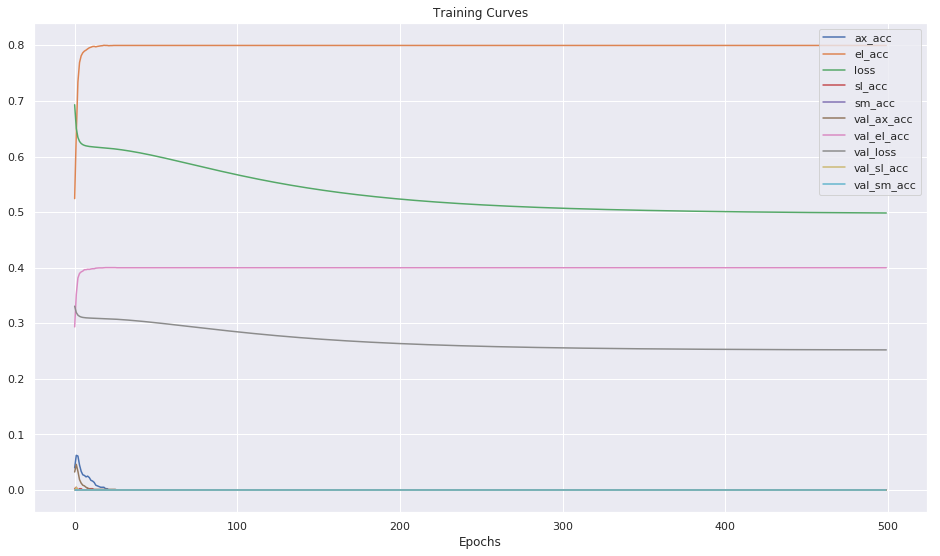

In [184]:
def exp_test():
    model.k = 0
    sess = new_session()
    metrics_list = []
    for i in range(1):
        metrics_list.append(train_hebbian(sess, lr=.01, epochs=EPOCHS, n_updates=3, init_ops=init_ops))
    return metrics_list
metrics = exp_test()
plt_metrics.plot_df_metrics(pd.DataFrame(metrics), title='Training Curves')
plt.show()

Completed epoch 1/1000. Metrics:
                     Loss   Sample Accuracy   Elem Accuracy
    Epoch:          0.6840       0.0000       0.5488
    Validation:     0.3281       0.0000       0.3130

[array([[-0.11103304, -0.15895411,  0.13516878, ...,  0.15339132,
        -0.13920185,  0.04619087],
       [ 0.10955822, -0.09949107,  0.05880077, ...,  0.12144537,
         0.09525783,  0.09041277],
       [-0.01198685, -0.05685747, -0.0069341 , ..., -0.13571517,
        -0.09030543, -0.13434088],
       ...,
       [ 0.04844423,  0.05227206,  0.05304167, ..., -0.16828215,
        -0.0226977 , -0.02896862],
       [ 0.08793505,  0.04425941, -0.16180862, ...,  0.07888462,
         0.14501731, -0.12523246],
       [-0.17367017, -0.165864  ,  0.07141508, ..., -0.08029346,
         0.12962359,  0.06321739]], dtype=float32), array([[ 0.43919164,  0.4675333 ,  0.27846065, ...,  0.46458772,
         0.31233498,  0.46885344],
       [ 0.35199183,  0.44354534,  0.30304983, ...,  0.48211846,
     

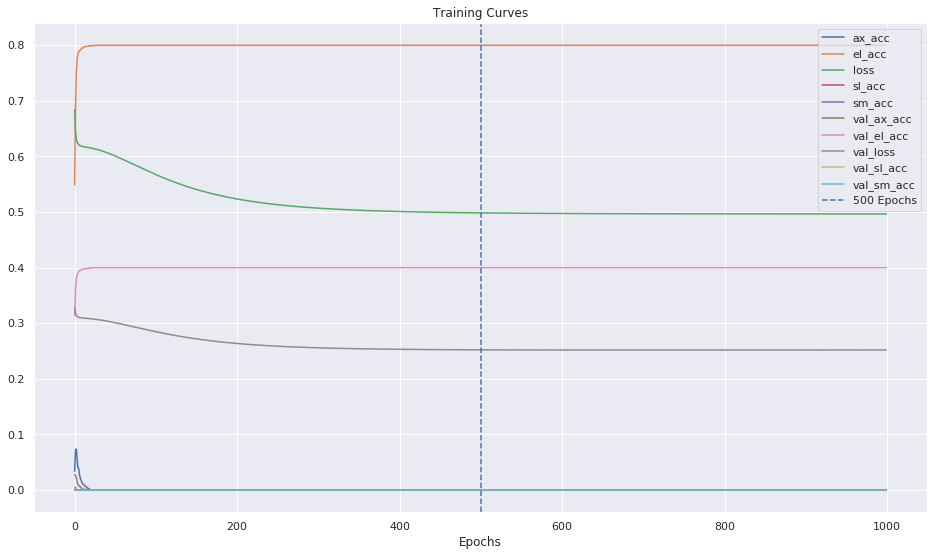

In [185]:
def exp_test():
    model.k = 0
    sess = new_session()
    metrics_list = []
    for i in range(1):
        metrics_list.append(train_hebbian(sess, lr=.01, epochs=2*EPOCHS, n_updates=3, init_ops=init_ops))
    return metrics_list
metrics = exp_test()
plt_metrics.plot_df_metrics(pd.DataFrame(metrics), title='Training Curves')
plt.show()